In [1]:
from src.analytical_upperbound import eps2_upper_bound
from src.exact_diagonalization import *
from src.fitting import *

%load_ext autoreload
%autoreload 2

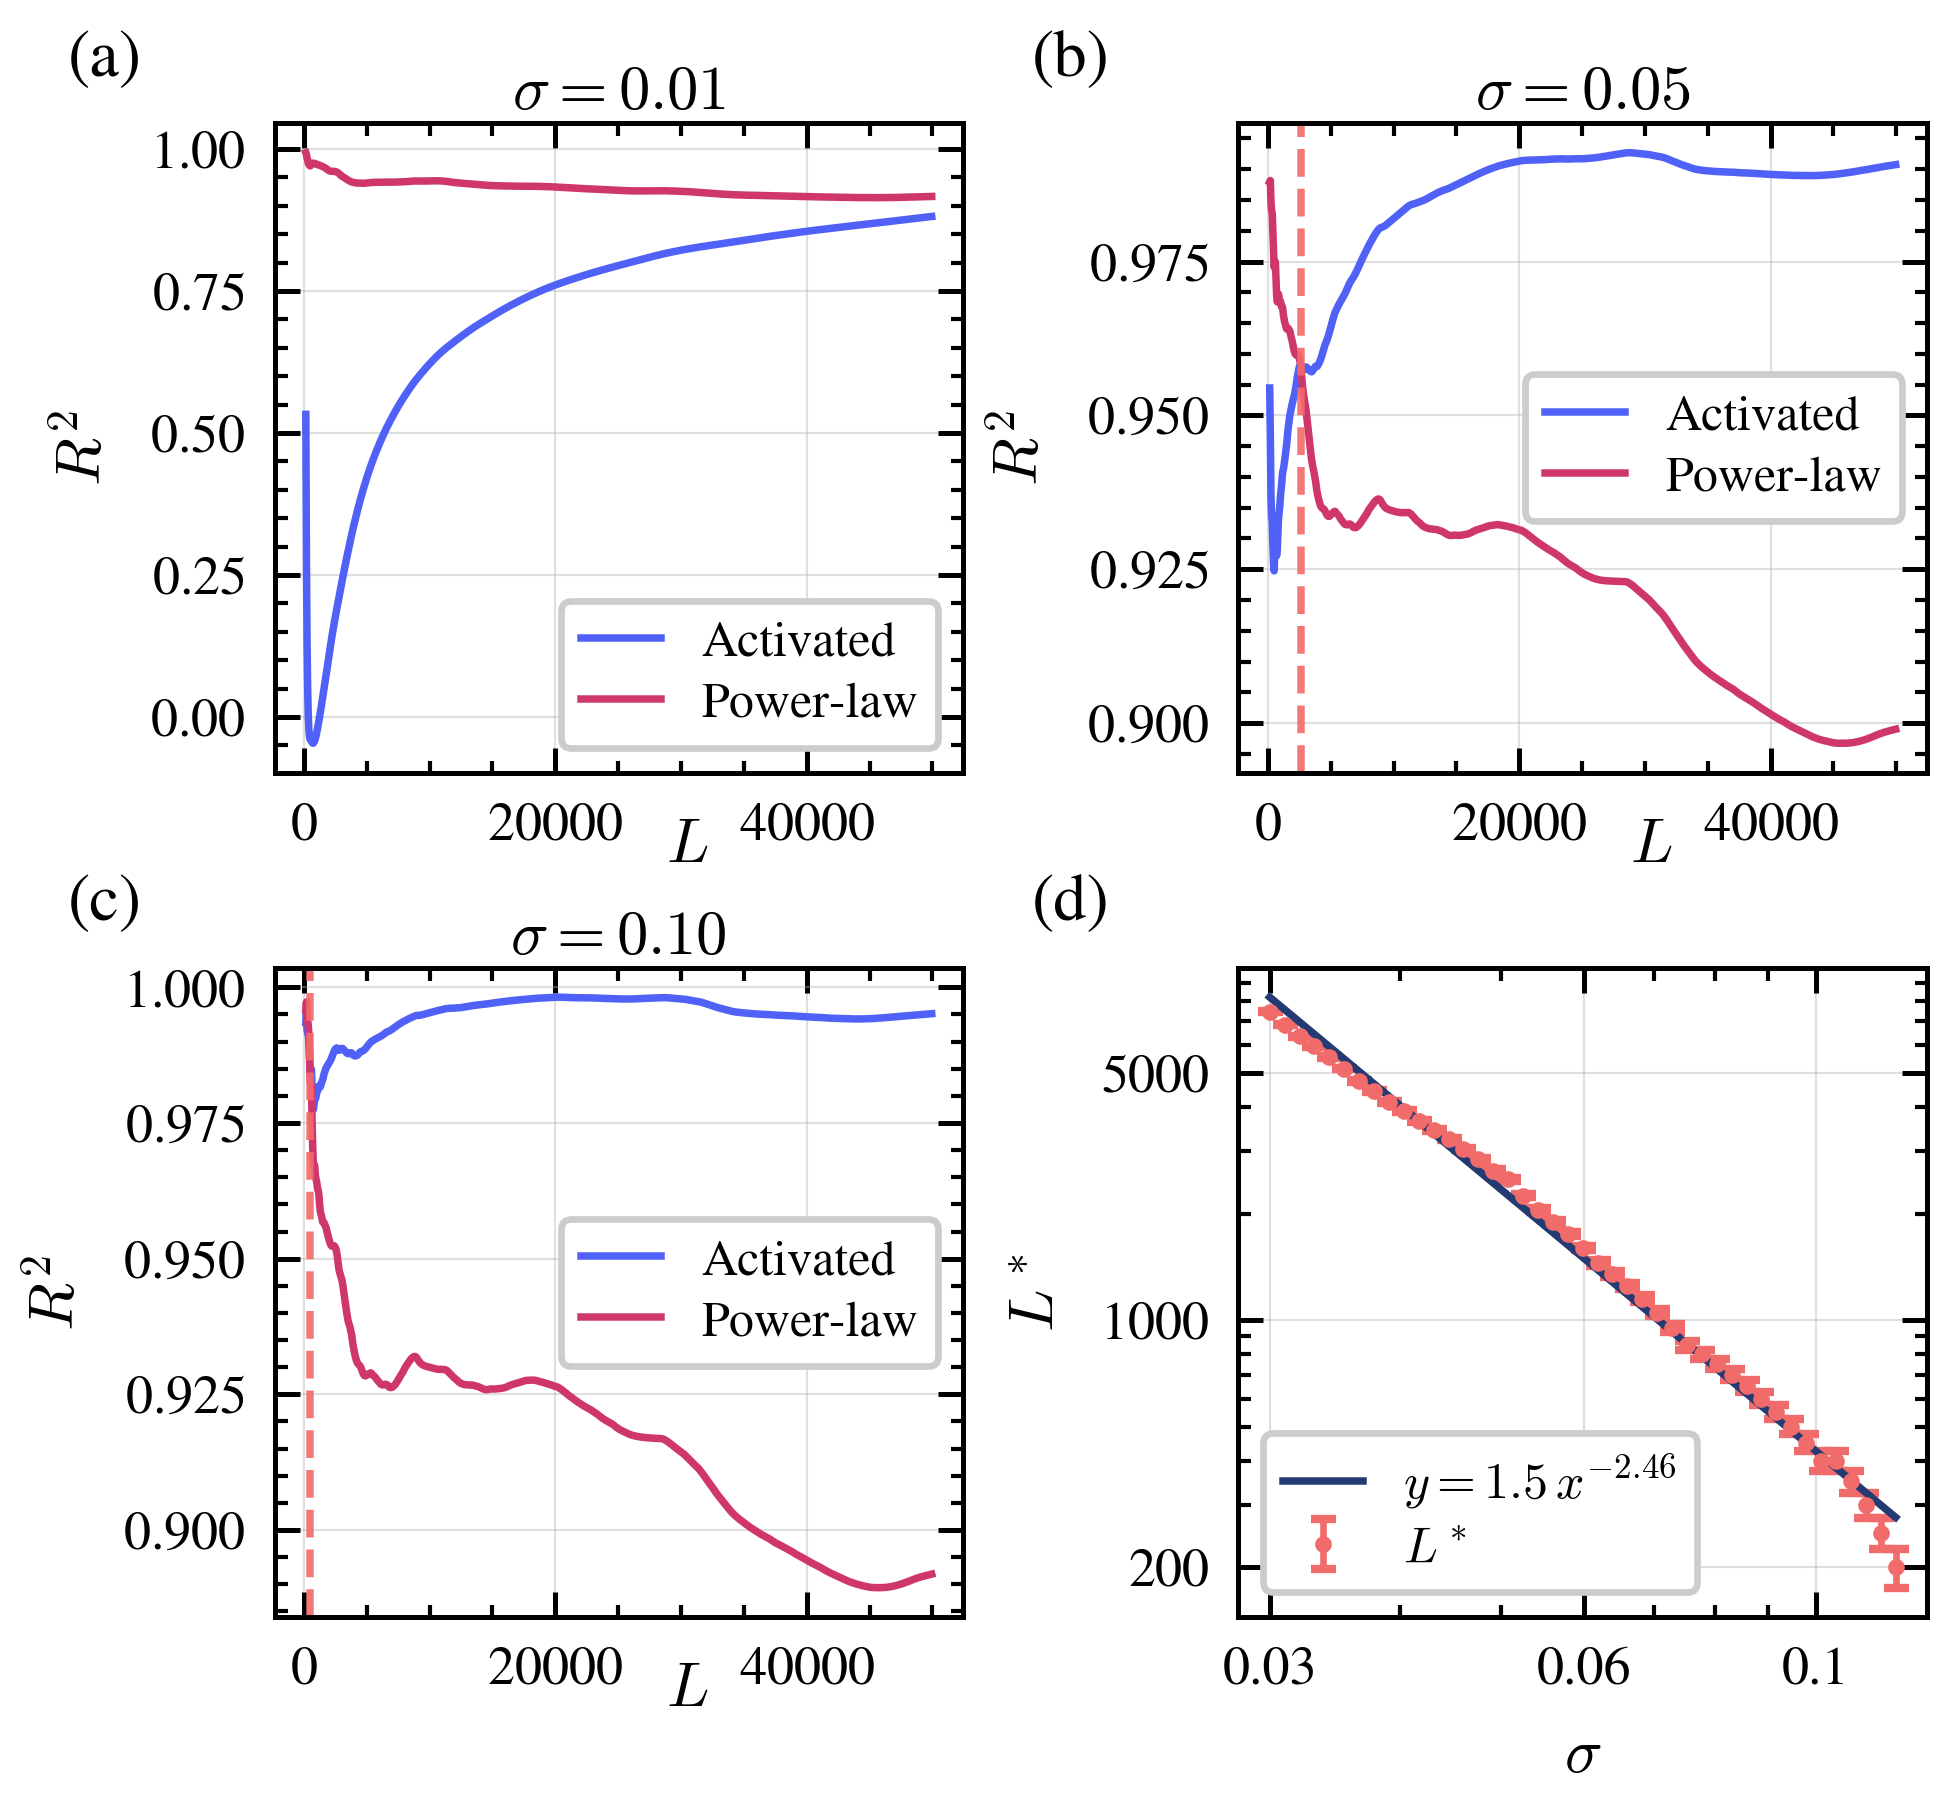

Fit over 0.030 <= sigma <= 0.120 (n=43):
  Exponent (alpha) = -2.4565
  Prefactor (A)    = 1.4885e+00
  R^2 (log-log)    = 0.9937


In [9]:
import re
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scienceplots

# ---------- you already have these somewhere ----------
# log_mean_stats(df, col="Delta_b")
# cumulative_curves_r2(L, mu, se, min_pts=3, use_weights=False)

# ---------- custom colors ----------
COL_LIGHT = "#4F61F7"  # blue (Delta_1 points/CI)
COL_MED   = "#CF366C"  # magenta-rose (Delta_p points/CI)

# separate colors for fit lines
COL_FIT1  = "#243A73"  # darker blue for fit Delta_1
COL_FIT2  = "#8B004B"  # darker magenta / wine for fit Delta_p

# distinct red for Delta_b
COL_UB    = "#F26B6B"  # coral red for Delta_b line + band

HIST_COLS = [COL_LIGHT, COL_MED, COL_FIT1]

# ---------- figure size for single-column RevTeX ----------
FIG_WIDTH_INCH  = 3.4
FIG_HEIGHT_INCH = 3.0

# ---------- map for Yukai file names ----------
sigma_str = {0.01: "0.01", 0.05: "0.05", 0.10: "0.1"}  # filenames use 0.1 not 0.10

def load_yukai_sigma(sigma, base_dir="data_ub/fig2"):
    """
    Load data for a given sigma and return a DataFrame with columns L, Delta_b.

    For sigma == 0.03, use data_Lstar_sigma_0.03_random_*.txt
    For sigma == 0.05 or 0.10, use data_sigma_<sigma>_random_*.txt
    """
    rows = []

    if abs(sigma - 0.03) < 1e-8:
        # use the Lstar-series files: data_Lstar_sigma_0.03_random_*.txt
        tag = f"{sigma:.2f}"
        pattern = str(Path(base_dir) / f"data_Lstar_sigma_{tag}_random_*.txt")
    else:
        # use the original sigma-series files: data_sigma_<tag>_random_*.txt
        tag = sigma_str[sigma]
        pattern = str(Path(base_dir) / f"data_sigma_{tag}_random_*.txt")

    for fpath in sorted(glob.glob(pattern)):
        data = np.loadtxt(fpath, max_rows=2)
        # first row: L; second row: Delta_b
        L_vals = data[0, :]
        Delta_b = data[1, :]

        for L, db in zip(L_vals, Delta_b):
            rows.append((float(L), float(db)))

    df = pd.DataFrame(rows, columns=["L", "Delta_b"])
    return df

# ---------- helper: compute L* from a DataFrame (R^2 version) ----------
def compute_L_star_for_df_r2(df, min_pts=3, use_weights=False):
    """
    Largest L where power law has higher R^2 than activated,
    using the same logic as compute_L_star_for_file_r2 but taking a DataFrame.
    """
    tbl = log_mean_stats(df, col="Delta_b")
    L, mu, se = tbl["L"].to_numpy(), tbl["mu"].to_numpy(), tbl["se"].to_numpy()
    curves = cumulative_curves_r2(L, mu, se, min_pts=min_pts, use_weights=use_weights)
    better = curves["R2_powerlaw_log"] > curves["R2_activated_log"]
    if better.any():
        return float(curves.loc[better, "L"].max())
    else:
        return np.nan

# ---------- compute L*(sigma) from Yukai data ----------
def compute_Lstar_vs_sigma(
    sigma_min_fit=0.03,
    sigma_max_fit=0.12,
    base_dir="data_ub/fig2",
):
    # files look like: data_ub/fig2/data_Lstar_sigma_0.08868622_random_40.txt
    all_files = sorted(glob.glob(str(Path(base_dir) / "data_Lstar_sigma_*.txt")))
    pat = re.compile(r"data_Lstar_sigma_([0-9.]+)_random_\d+\.txt$")

    # group file paths by sigma
    sigma_to_paths = {}
    for f in all_files:
        m = pat.search(Path(f).name)
        if not m:
            continue
        sigma = float(m.group(1))
        sigma_to_paths.setdefault(sigma, []).append(f)

    rows = []
    for sigma, paths in sorted(sigma_to_paths.items()):
        # collect all (L, Delta_b) from all random_* files for this sigma
        dfs = []
        for f in paths:
            arr = np.loadtxt(f, max_rows=2)
            L_vals = arr[0, :]
            Delta_b = arr[1, :]
            dfs.append(pd.DataFrame({"L": L_vals, "Delta_b": Delta_b}))

        df_sigma = pd.concat(dfs, ignore_index=True)
        df_sigma = df_sigma[df_sigma["L"] > 0]

        L_star = compute_L_star_for_df_r2(df_sigma, min_pts=3, use_weights=False)
        rows.append((sigma, L_star))

    if not rows:
        raise RuntimeError(f"No matching Yukai files found in {base_dir}/")

    res = (
        pd.DataFrame(rows, columns=["sigma", "L_star"])
        .sort_values("sigma")
        .reset_index(drop=True)
    )

    # restrict BOTH fit and plot to [sigma_min_fit, sigma_max_fit]
    mask = (
        (res["sigma"] >= sigma_min_fit)
        & (res["sigma"] <= sigma_max_fit)
        & (res["L_star"] > 0)
    )
    df_fit = res.loc[mask, ["sigma", "L_star"]].copy()
    df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna()

    x = np.log(df_fit["sigma"].to_numpy())     # ln sigma
    y = np.log(df_fit["L_star"].to_numpy())   # ln L*
    m, b = np.polyfit(x, y, 1)

    alpha = m
    A = np.exp(b)

    y_pred = m * x + b
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - y.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    return res, df_fit, A, alpha, r2


# ==============================================================
# 2×2 RevTeX-style figure: (a,b,c) cumulative R^2; (d) L* vs sigma
# ==============================================================

with plt.style.context(["science", "ieee", "no-latex"]):

    # global styling: fonts and line widths
    plt.rcParams.update({
        # fonts (smaller than RevTeX 10pt body text)
        "font.size": 7.5,
        "axes.labelsize": 7.5,
        "axes.titlesize": 7.5,
        "xtick.labelsize": 6.5,
        "ytick.labelsize": 6.5,
        "legend.fontsize": 6,

        # line widths
        "axes.linewidth": 0.6,
        "lines.linewidth": 0.9,
        "lines.markersize": 1,
        "patch.linewidth": 0.8,

        # ticks
        "xtick.major.width": 0.6,
        "ytick.major.width": 0.6,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "xtick.minor.size": 1.5,
        "ytick.minor.size": 1.5,

        # grid
        "grid.linewidth": 0.25,
        "grid.alpha": 0.4,

        # legend frame
        "legend.frameon": True,
        "legend.fancybox": True,
        "legend.framealpha": 1.0,
    })

    fig, axs = plt.subplots(2, 2, figsize=(FIG_WIDTH_INCH, FIG_HEIGHT_INCH))

    # fairly tight layout for 2x2 panels in a square single column
    plt.subplots_adjust(
        left=0.18, right=0.99,
        bottom=0.16, top=0.99,
        wspace=0.4, hspace=0.3
    )

    # ----------------------------------------------------------
    # Panels (a), (b), (c): cumulative R^2 vs L for three sigmas
    # ----------------------------------------------------------
    sigmas = [0.01, 0.05, 0.10]
    panel_labels = ["(a)", "(b)", "(c)"]
    axes_cum = [axs[0, 0], axs[0, 1], axs[1, 0]]

    for sigma, ax, lab in zip(sigmas, axes_cum, panel_labels):
        df = load_yukai_sigma(sigma)
        df = df[df["L"] < 50000]

        tbl = log_mean_stats(df, col="Delta_b")
        L  = tbl["L"].to_numpy()
        mu = tbl["mu"].to_numpy()
        se = tbl["se"].to_numpy()

        cum_df = cumulative_curves_r2(L, mu, se, min_pts=3, use_weights=False)

        # --- labels only where you want legends ---

        # R^2 legends only in sigma = 0.01 panel
        label_act = r"Activated"
        label_pow = r"Power-law"

        ax.plot(
            cum_df["L"], cum_df["R2_activated_log"],
            marker="None", linestyle="-",
            color=COL_LIGHT,
            label=label_act,
        )
        ax.plot(
            cum_df["L"], cum_df["R2_powerlaw_log"],
            marker="None", linestyle="-",
            color=COL_MED,
            label=label_pow,
        )

        # L* vline + legend in sigma = 0.05 and 0.10 panels
        if np.isclose(sigma, 0.05) or np.isclose(sigma, 0.10):
            L_star = compute_L_star_for_df_r2(df, min_pts=3, use_weights=False)
            ax.axvline(
                L_star,
                color=COL_UB,       # coral red
                linestyle="--",
                linewidth=0.9,
                alpha=0.9,
                # label=rf"$L^*={int(L_star):d}$",
            )

        ax.set_title(rf"$\sigma = {sigma:.2f}$", pad=0)
        ax.grid(True, alpha=0.4)
        ax.set_ylabel(r"$R^2$")
        ax.set_xlabel(r"$L$")
        ax.xaxis.set_label_coords(0.6, -0.07)

        # draw legend only if there is something labeled on this axis
        handles, labels_ = ax.get_legend_handles_labels()
        if handles:  # non-empty
            ax.legend(loc="best", handlelength=1.6, labelspacing=0.3)

        # panel label
        ax.text(
            -0.30, 1.05, lab, transform=ax.transAxes,
            fontsize=8.0, va="bottom", ha="left"
        )


    # ----------------------------------------------------------
    # Panel (d): L* vs sigma (log-log) with fit
    # ----------------------------------------------------------
    sigma_min_fit = 0.03
    sigma_max_fit = 0.12

    res, df_fit, A, alpha, r2 = compute_Lstar_vs_sigma(
        sigma_min_fit=sigma_min_fit,
        sigma_max_fit=sigma_max_fit,
        base_dir="data_ub/fig2",
    )

    ax_d = axs[1, 1]

    ax_d.errorbar(
        df_fit["sigma"],
        df_fit["L_star"],
        yerr=25,              
        xerr=None,            
        fmt="o",              
        linestyle="",
        color=COL_UB,
        label=rf"$L^*$",
        capsize=1.5,            
        elinewidth=0.8,         
    )

    # fit line
    smin, smax = df_fit["sigma"].min(), df_fit["sigma"].max()
    sigma_line = np.geomspace(smin, smax, 200)
    Lstar_line = A * sigma_line ** alpha
    ax_d.plot(
        sigma_line,
        Lstar_line,
        linestyle="-",
        color=COL_FIT1,
        label=rf"$y = {A:.2g}\,x^{{{alpha:.2f}}}$",
    )

    from matplotlib.ticker import FixedLocator, NullLocator, FuncFormatter

    ax_d.set_xscale("log")
    ax_d.set_yscale("log")

    ax_d.set_xlabel(r"$\sigma$")
    ax_d.set_ylabel(r"$L^*$")

    # major ticks
    xticks = np.array([0.03, 0.06, 0.10])
    yticks = np.array([200, 1000, 5000])
    ax_d.set_xticks(xticks)
    ax_d.set_yticks(yticks)

    ax_d.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: f"{x:g}")  # 0.03, 0.06, 0.1 ...
    )
    ax_d.yaxis.set_major_formatter(
        FuncFormatter(lambda y, pos: f"{y:g}")  # 200, 1000, 5000 ...
    )

    # ax_d.set_xticklabels([
    #     r"$3\times10^{-2}$",
    #     r"$6\times10^{-2}$",
    #     r"$1\times10^{-1}$",
    # ])
    # ax_d.set_yticklabels([
    #     r"$2\times10^{2}$",
    #     r"$1\times10^{3}$",
    #     r"$5\times10^{3}$",
    # ])

    # this removes the 0.04 tick
    ax_d.tick_params(axis="x", which="minor", labelbottom=False)
    ax_d.grid(True, which="major", alpha=0.4)   # grid only on major ticks
    ax_d.grid(False, which="minor")

    ax_d.legend(loc="lower left", handlelength=1.6, labelspacing=0.3)

    ax_d.text(-0.30, 1.05, "(d)", transform=ax_d.transAxes,
            fontsize=8.0, va="bottom", ha="left")


    # done
    fig.savefig("figures/fig2.pdf", bbox_inches="tight")
    plt.show()

# if you still want to print the fit numbers:
print(f"Fit over {sigma_min_fit:.3f} <= sigma <= {sigma_max_fit:.3f} (n={len(df_fit)}):")
print(f"  Exponent (alpha) = {alpha:.4f}")
print(f"  Prefactor (A)    = {A:.4e}")
print(f"  R^2 (log-log)    = {r2:.4f}")
